# W4671 Final Project

## Using DNABert to Improve Microbiome OTU clustering for Colorectal Cancer Prediction
## George Austin, gia2105

### Data Setup

In [31]:
# setups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering as AC



### DNABERT stuff
import sys
sys.path.append("../DNABERT/examples/data_process_template")
sys.path.append("../DNABERT/examples/")
sys.path.append("../DNABERT/src")
import process_690
import run_pretrain
import run_finetune

### Dataset stuff

#### pulling the reads
kmer = 6
reads_path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.otu_seqs.100.fasta'
reads_ = pd.read_csv(reads_path, sep = ',', header = None)


# for the first reads_path

qq = 3
__ = reads_.iloc[range(reads_.shape[0])[1::qq]].reset_index()[0]
for i in range(2, qq):
    __ = __ + reads_.iloc[range(reads_.shape[0])[i::qq]].reset_index()[0]
    
reads = pd.DataFrame(\
 {'label':reads_.iloc[range(reads_.shape[0])[::qq]].reset_index()[0] ,\
  'elements':__,
  })
reads['label'] = reads.label.str[1:]


## getting data in the right format for DNAbert
def kmerify(row):
    return(process_690.get_kmer_sentence( row.elements, kmer=6))


reads['kmers'] = reads.apply( kmerify, axis = 1 )


## setting up DNABert model
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
from copy import deepcopy
from multiprocessing import Pool

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

# a lot of this code is from DNABert's repo
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertModel,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    DNATokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "dna": (BertConfig, BertForMaskedLM, DNATokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}


## standard code for loading pretrained huggingface model
config_class, model_class, tokenizer_class = MODEL_CLASSES['dna']

config = config_class.from_pretrained('../DNABERT_model_6/',\
                                      cache_dir='cache/')
config.output_hidden_states = True

tokenizer = tokenizer_class.from_pretrained('../DNABERT_model_6/',\
                                cache_dir='cache/')

model = BertModel.from_pretrained(  '../DNABERT_model_6',
            cache_dir= 'cache/',
            config = config)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
reads.tail()

,label,elements,kmers
832,denovo833,TGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTCGC...,TGAGGA GAGGAA AGGAAT GGAATA GAATAT AATATT ATAT...
833,denovo834,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCGACGCCGC...,TGGGGA GGGGAA GGGAAT GGAATA GAATAT AATATT ATAT...
834,denovo835,GGCACGGAGTTAGCCGATCCTTATTCATAGGGTACATACAAAACGG...,GGCACG GCACGG CACGGA ACGGAG CGGAGT GGAGTT GAGT...
835,denovo836,GGCACGGAGTTAGCCGGTGCTTCTTCTGCGGGTAACGTCAATCACT...,GGCACG GCACGG CACGGA ACGGAG CGGAGT GGAGTT GAGT...
836,denovo837,GGCACGTAGTTAGCCGGAGCTTATTCTACAGGTACTGTCCTTTCTC...,GGCACG GCACGT CACGTA ACGTAG CGTAGT GTAGTT TAGT...


In [3]:
%%time
## creating the reads -- using sbert-wk implementation
from sbert_wk_functions import create_embeddings, generate_embedding

embeddings = create_embeddings(list(reads.kmers), model, tokenizer, use_sbert = True)

reads['idx'] = reads.index

# 3 minutes/800 reads -- pretty good tim

CPU times: user 3min 21s, sys: 10.9 s, total: 3min 32s
Wall time: 3min 23s


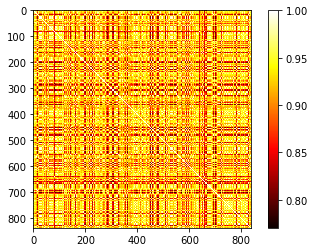

In [4]:
n = len(embeddings)
sims = np.zeros((n, n))

#getting cosine similarities -- theres probably a good function for this...
for i in range(n):
    for j in range(i, n):
        sims[i,j] = embeddings[i].dot(embeddings[j])/ \
                    (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))

sims = sims + sims.T - np.eye(sims.shape[0])

#visualizing similarity matrix
plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

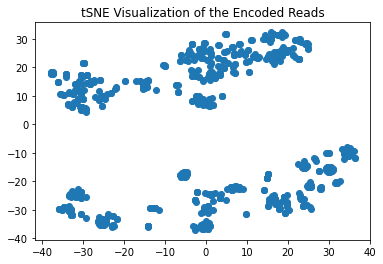

In [5]:
#visualizing representations of the reads
pc = PCA(n_components = 100)
ts = TSNE(n_components = 2, perplexity = 30)

viz = ts.fit_transform( pc.fit_transform(embeddings) )
plt.scatter(viz[:,0], viz[:, 1])
plt.title('tSNE Visualization of the Encoded Reads')
plt.show()

In [6]:
# reading/set up the otu abundance matrix
path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.otu_table.100.denovo'

df = pd.read_csv(path, sep = '\t')
df.index = df[df.columns[0]]
df_fixed = df.drop(df.columns[0], axis = 1).transpose()
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
df_fixed = df_fixed[[a for a in reads.label]]
df_fixed.head()

OTU_ID,denovo1,denovo2,denovo3,denovo4,denovo5,denovo6,denovo7,denovo8,denovo9,denovo10,...,denovo828,denovo829,denovo830,denovo831,denovo832,denovo833,denovo834,denovo835,denovo836,denovo837
C45,0.295455,0.000000,0.045455,0.000000,0.000000,0.022727,0.000000,0.007576,0.037879,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C31,0.146245,0.051383,0.015810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C07,0.133333,0.018519,0.011111,0.000000,0.022222,0.037037,0.003704,0.000000,0.022222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C13,0.013636,0.050000,0.018182,0.086364,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H12,0.072165,0.010309,0.041237,0.072165,0.010309,0.000000,0.025773,0.000000,0.000000,0.159794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# set up prediction task
metadata_path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.metadata.txt'

metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')

metadata['Var'] = metadata.DiseaseState
metadata['#Sample ID'] = metadata['#SampleID']
metadata = metadata[['#Sample ID', 'Var']]
metadata.head()

,#Sample ID,Var
0,C01,CRC
1,C03,CRC
2,C05,CRC
3,C07,CRC
4,C09,CRC


In [8]:
def test_reduced_dims(df_fixed, response, embeddings, n_dims, names, f = 'rf'):
    """
    reduces the dimensions by aggregating based on cluster similarity
    """
    cm = AC(n_clusters = int(n_dims), affinity = 'cosine', linkage='average')
    cm.fit(embeddings)
    names['cluster'] = cm.labels_
    
    reduced = df_fixed.copy()
    reduced.columns = names.cluster
    #reduced = reduced.transpose().groupby('cluster').sum().transpose()
    red = reduced.transpose()
    reduced = red.groupby(red.index).sum().transpose()

    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        try:
            y_train, y_test = y[train_index], y[test_index]
        except:
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if f == 'rf':
            rf = RandomForestClassifier(n_estimators = 100)
        else:
            rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )
        
    
    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)
        
    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)
        
    return(fpr, tpr, auc_val, n_dims)

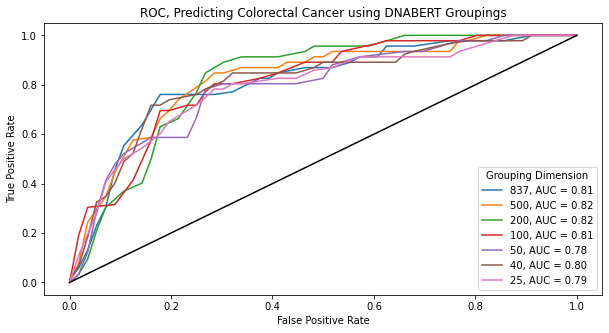

In [9]:
#show performance of DNABert hierarchal clustering
L = []

for i in [df_fixed.shape[1], 500, 200, 100, 50, 40, 25]:
    L.append( test_reduced_dims(df_fixed, metadata, embeddings, i, reads) )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using DNABERT Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [32]:
# Mapping clusters to phylogeny, exploring the cases where the clusters differ,
# and how it relates to interpretable signals from logistic regression

phylos = pd.read_csv('../MicrobiomeHD_data/crc_zhao_results/RDP/crc_zhao.otu_table.100.denovo.rdp_assigned', sep = '\t')['Unnamed: 0']

otu_phylo = pd.DataFrame( \
        dict( {'otu':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[-1], 
        'phylogeny':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[:-1].str.join(' ') } ) 
          )

# taking dimension of 100, consistently giving good results
clusterer = AC(n_clusters=50, linkage="average", affinity='cosine')
clusterer.fit(embeddings)
reads['cluster'] = clusterer.labels_

merged_info = otu_phylo.merge(reads, how = 'inner', left_on = 'otu', right_on = 'label')[['otu', 'phylogeny', 'cluster']]


reduced = df_fixed.copy()
reduced.columns = reads.cluster
red = reduced.transpose()
reduced = red.groupby(red.index).sum().transpose()

response = metadata
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

PREDS = []
TRUES = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

cluster_summaries = merged_info.groupby('cluster')['phylogeny'].agg(lambda x: dict(x.value_counts())).reset_index()

cluster_summaries['coef'] = rf.coef_[0]

# observing the clusters corresponding to significant coefficients
for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
    print(cluster_summaries.phylogeny[i])
    print(cluster_summaries.coef[i])

{' Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides': 72, ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Prevotellaceae Prevotella': 23, ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Porphyromonadaceae Parabacteroides': 19, ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Prevotellaceae Paraprevotella': 4, ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Porphyromonadaceae Porphyromonas': 3, ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Porphyromonadaceae Odoribacter': 2}
-2.587420177963748


In [11]:
def get_amount_in_data(row):
    return( (otu_phylo.phylogeny == row ).sum() )

In [12]:
sig_ = cluster_summaries.loc[cluster_summaries.coef != 0].phylogeny[1] 
[get_amount_in_data(row) for row in sig_.keys()]

[126, 36, 31, 5, 7, 4]

In [13]:
(otu_phylo.phylogeny == ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides' ).sum()

126

In [14]:
(otu_phylo.phylogeny == ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Prevotellaceae Prevotella').sum()

36

there are 126 - 72 = 54 'Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides' OTUs that are excluded from this cluster. Every observed phylogeny in the significant cluster has OTUs that are removed from the cluster. From comparing to the below phylogenetic cluster, these deviations are leading to significant improvement in performances. 

In [15]:
# exploring logistic regression results when grouping by phylogenetic assignment
def test_reduce_by_phylo_name(df_fixed, response, n_cutoffs,  names, f = 'rf'):
    cluster = names.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')


    reduced = df_fixed.copy()
    reduced.columns = cluster
    reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)

    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

    #doing K-Fold cross validation, to get 100+ predictions

    #     X_train, X_test, y_train, y_test = train_test_split(\
    #                         X, y, test_size=0.15, random_state=42)
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if f == 'rf':
            rf = RandomForestClassifier(n_estimators = 100)
        else:
            rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )

    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)

    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)

    return(fpr, tpr, auc_val, X.shape[1] )

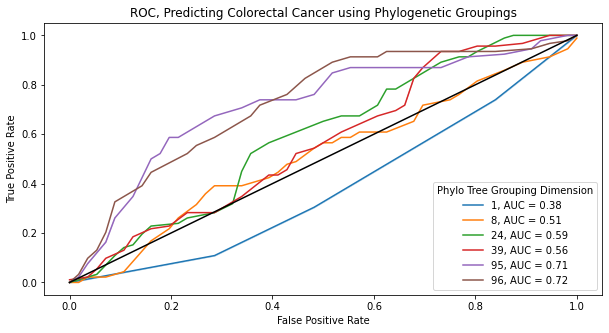

In [16]:
response = metadata  
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo, f = 'rf') )
    

phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]


plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Observations:
- We have a significant gains in CRC prediction from applying the DNAbert dimensionality reduction clustering. We basically can't identify key elements with just phylogeny

In [17]:
n_cutoffs = 7
cluster = merged_info.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')

reduced = df_fixed.copy()
reduced.columns = cluster
reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
#print(n_cutoffs, X.shape)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

phylo_group_results = pd.DataFrame(dict({ 'phylo':reduced.columns, 
                     'coef':rf.coef_[0] }))

for i in phylo_group_results.loc[phylo_group_results.coef != 0].index:
    print(phylo_group_results.phylo[i])
    print(phylo_group_results.coef[i])

# #rf.coef_

# for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
#     print(cluster_summaries.phylogeny[i])
#     print(cluster_summaries.coef[i])

In [18]:
import biom

In [19]:
# file_path = '../MicrobiomeHD_data/crc_zhao.otu_seqs.100.fasta'

# os.system('sumaclust -t .999 -B test_.txt ../MicrobiomeHD_data/crc_zhao.otu_seqs.100.fasta')
# # + file_path)
    
# p = biom.load_table('test_.txt')# biom.load_table('../MicrobiomeHD_data/crc_zhao_results/test/test.txt')
# sumaclust_df = pd.DataFrame(p)
# cluster = np.vstack([a for a in sumaclust_df[0].values]).argmax(axis = 1)
# otu_order = np.array( sumaclust_df[1].str[6:].astype(int) )

In [20]:
# p = biom.load_table('test.txt')# biom.load_table('../MicrobiomeHD_data/crc_zhao_results/test/test.txt')
# sumaclust_df = pd.DataFrame(p)
# cluster = np.vstack([a for a in sumaclust_df[0].values]).argmax(axis = 1)
# otu_order = np.array( sumaclust_df[1].str[6:].astype(int) )

In [21]:
def test_reduced_sumaclust(df_fixed, response, threshold, file_path, names, f = 'rf'):
    """
    reduces the dimensions by aggregating based on cluster similarity
    """
    os.system('sumaclust -t '+str(threshold)+ ' -B test.txt ' + file_path)
    
    p = biom.load_table('test.txt')# biom.load_table('../MicrobiomeHD_data/crc_zhao_results/test/test.txt')
    sumaclust_df = pd.DataFrame(p)
    cluster = np.vstack([a for a in sumaclust_df[0].values]).argmax(axis = 1)
    otu_order = np.array( sumaclust_df[1].str[6:].astype(int) )
    
    arr1 = otu_order
    arr2 = cluster
    arr1inds = arr1.argsort()
    sorted_arr1 = arr1[arr1inds[::-1]]
    sorted_arr2 = arr2[arr1inds]    
    names.cluster = sorted_arr2
    
    reduced = df_fixed.copy()
    reduced.columns = names.cluster
    #reduced = reduced.transpose().groupby('cluster').sum().transpose()
    red = reduced.transpose()
    reduced = red.groupby(red.index).sum().transpose()

    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        try:
            y_train, y_test = y[train_index], y[test_index]
        except:
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if f == 'rf':
            rf = RandomForestClassifier(n_estimators = 100)
        else:
            rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )
        
    
    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)
        
    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)
        
    return(fpr, tpr, auc_val, X.shape[1])

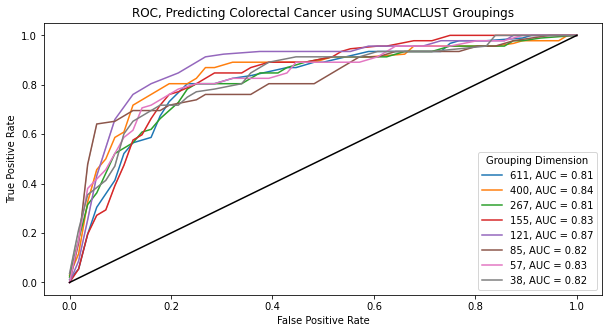

In [22]:
#show performance of DNABert hierarchal clustering
L = []
file_path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.otu_seqs.100.fasta'
for threshold in [.99, .98, .95, .9, .88, .85, .83, .8]:
    L.append( test_reduced_sumaclust(df_fixed, metadata, threshold, file_path,  reads) )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = sum_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using SUMACLUST Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [23]:
#show performance of DNABert hierarchal clustering
L = []
file_path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.otu_seqs.100.fasta'
for threshold in list( np.linspace(.75, 1, 30) ):#*3:
    L.append( test_reduced_sumaclust(df_fixed, metadata, threshold, file_path,  reads, f = 'rf') )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

In [24]:
L = []

for i in list(np.linspace(25, df_fixed.shape[1], 30, dtype = np.uint64)):#*3:
               # [df_fixed.shape[1], 500, 200, 100, 50, 40, 25]:
    L.append( test_reduced_dims(df_fixed, metadata, embeddings, i, reads, f = 'rf') )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' 


In [25]:
response = metadata  
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo, f = 'rf') )
    

phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]



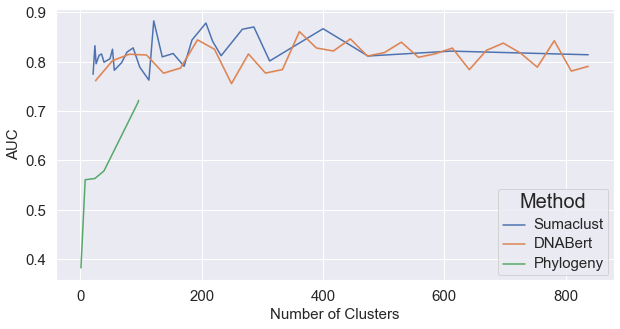

In [26]:
auc_summary = sum_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary_ = full_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary['Method'] = 'Sumaclust'
auc_summary_['Method'] = 'DNABert'
phylo_results['n_dims'] = phylo_results.n_cutoffs
auc_summary__ = phylo_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary__['Method'] = 'Phylogeny'

auc_summary = pd.concat((auc_summary, auc_summary_, auc_summary__), axis = 0)



auc_summary = pd.concat((auc_summary, auc_summary_), axis = 0)
sns.set_theme()
plt.figure(figsize=(10,5))
ax = sns.lineplot(x = 'n_dims', y = 'auc', 
             data = auc_summary,\
             ci= 0, hue = 'Method') 

#plt.title('Comparing Random Forest AUCs across Clustering Methods')
plt.xlabel("Number of Clusters", fontsize = 15)
plt.ylabel("AUC", fontsize = 15)
plt.setp( ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='20')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('crc_zhao_rf.png', pad_inches = 0)
plt.show()

0
1
2


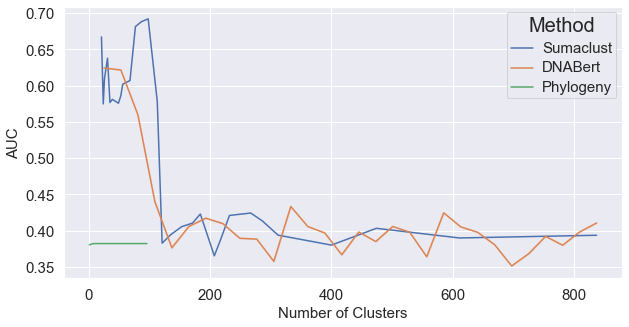

In [27]:
#show performance of DNABert hierarchal clustering
L = []
file_path = '../MicrobiomeHD_data/crc_zhao_results/crc_zhao.otu_seqs.100.fasta'
for threshold in list( np.linspace(.75, 1, 30) )*3:
    L.append( test_reduced_sumaclust(df_fixed, metadata, threshold, file_path,  reads, f = '_') )

print('0')
sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]
    
L = []

for i in list(np.linspace(25, df_fixed.shape[1], 30, dtype = np.uint64))*3:
               # [df_fixed.shape[1], 500, 200, 100, 50, 40, 25]:
    L.append( test_reduced_dims(df_fixed, metadata, embeddings, i, reads, f = '_') )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \

response = metadata  
G = []
for i in [1, 2, 3, 4, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo, f = '_') )
    
print('1' )
phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]
print('2')

auc_summary = sum_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary_ = full_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary['Method'] = 'Sumaclust'
auc_summary_['Method'] = 'DNABert'
phylo_results['n_dims'] = phylo_results.n_cutoffs
auc_summary__ = phylo_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary__['Method'] = 'Phylogeny'

auc_summary = pd.concat((auc_summary, auc_summary_, auc_summary__), axis = 0)



auc_summary = pd.concat((auc_summary, auc_summary_), axis = 0)
sns.set_theme()
plt.figure(figsize=(10,5))
ax = sns.lineplot(x = 'n_dims', y = 'auc', 
             data = auc_summary,\
             ci= 0, hue = 'Method') 

#plt.title('Comparing Random Forest AUCs across Clustering Methods')
plt.xlabel("Number of Clusters", fontsize = 15)
plt.ylabel("AUC", fontsize = 15)
plt.setp( ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='20')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('crc_zhao_lr.png', pad_inches = 0)
plt.show()
